# ALEXNET

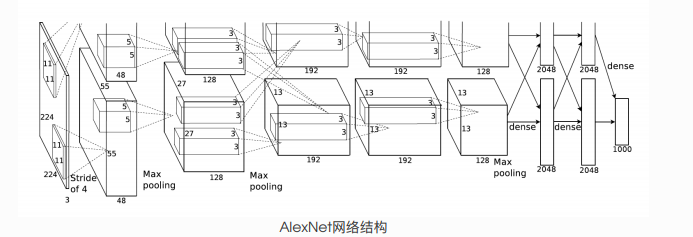

它⾸次证明了学习到的特征可以超越⼿⼯设计的特征，从⽽⼀举打破计算机视觉研究的前状

<p>第⼀，与相对较⼩的LeNet相⽐，AlexNet包含8层变换，其中有5层卷积和2层全连接隐藏层，以及1个
全连接输出层。下⾯我们来详细描述这些层的设计。</p>
<p>AlexNet第⼀层中的卷积窗⼝形状是11x11 。因为ImageNet中绝⼤多数图像的⾼和宽均⽐MNIST图像
的⾼和宽⼤10倍以上，ImageNet图像的物体占⽤更多的像素，所以需要更⼤的卷积窗⼝来捕获物体。
第⼆层中的卷积窗⼝形状减⼩到5x5 ，之后全采⽤3x3 。此外，第⼀、第⼆和第五个卷积层之后都使
⽤了窗⼝形状为3x3 、步幅为2的最⼤池化层。⽽且，AlexNet使⽤的卷积通道数也⼤于LeNet中的卷
积通道数数⼗倍。</p>
<p>紧接着最后⼀个卷积层的是两个输出个数为4096的全连接层。这两个巨⼤的全连接层带来将近1 GB的
模型参数。由于早期显存的限制，最早的AlexNet使⽤双数据流的设计使⼀个GPU只需要处理⼀半模
型。幸运的是，显存在过去⼏年得到了⻓⾜的发展，因此通常我们不再需要这样的特别设计了。</p>
<p>第⼆，AlexNet将sigmoid激活函数改成了更加简单的ReLU激活函数。⼀⽅⾯，ReLU激活函数的计算更
简单，例如它并没有sigmoid激活函数中的求幂运算。另⼀⽅⾯，ReLU激活函数在不同的参数初始化⽅
法下使模型更容易训练。这是由于当sigmoid激活函数输出极接近0或1时，这些区域的梯度⼏乎为0，
从⽽造成反向传播⽆法继续更新部分模型参数；⽽ReLU激活函数在正区间的梯度恒为1。因此，若模型
参数初始化不当，sigmoid函数可能在正区间得到⼏乎为0的梯度，从⽽令模型⽆法得到有效训练。</p>
<p>第三，AlexNet通过丢弃法来控制全连接层的模型复杂度。⽽LeNet并没有使⽤丢弃法。</p>
<p>第四，AlexNet引⼊了⼤量的图像增⼴，如翻转、裁剪和颜⾊变化，从⽽进⼀步扩⼤数据集来缓解过拟
合。</p>

In [1]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn,optim
import sys

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(1,96,11,4),# in_channels, out_channels,kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3,2),# kernel_size, stride
            nn.Conv2d(96,256,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(256,384,3,1,1),
            nn.ReLU(),
            nn.Conv2d(384,384,3,1,1),
            nn.ReLU(),
            nn.Conv2d(384,256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        # 这⾥全连接层的输出个数⽐LeNet中的⼤数倍。使⽤丢弃层来缓解过拟合
        self.fc=nn.Sequential(
            nn.Linear(256*5*5,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,10),
        )
    def forward(self,img):
        feature=self.conv(img)
        output=self.fc(feature.view(img.shape[0],-1))
        return output

In [2]:
net=AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

# 读取数据

In [9]:
def load_data_fashion_mnist(batch_size,resize=None,root='./Datasets/FashionMNIST'):
    trans=[]
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform=torchvision.transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root=root,train=True,download=True,transform=transform)
    mnist_test=torchvision.datasets.FashionMNIST(root=root,train=False,download=True,transform=transform)
    train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=0)
    test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=0)
    return train_iter,test_iter

batch_size=1
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=224)

# 训练

In [12]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

In [10]:
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on ',device)
    loss=torch.nn.CrossEntropyLoss()
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.lf sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))

In [11]:
lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda


KeyboardInterrupt: 

In [39]:
torch.cuda.empty_cache()